# SHAP Analysis (Section 8.3)

Feature importance and explainability for the NHL point prediction model.
Uses TreeExplainer (fast for XGBoost) to compute SHAP values on the validation set.

**Setup:** Run the cell below once to install `shap`, then restart the kernel (Kernel → Restart). Start Jupyter from project root (`jupyter notebook notebooks/shap_analysis.ipynb`) or from `notebooks/` (`jupyter notebook shap_analysis.ipynb`) so paths resolve.


In [1]:
# Run this cell once to install shap. Restart the kernel after (Kernel → Restart), then run the rest.
%pip install shap


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
from pathlib import Path

import joblib
import pandas as pd
import shap
import yaml

# Project root (notebook is in notebooks/)
root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
with open(root / "model_registry.json") as f:
    registry = json.load(f)
model_version = registry.get("current_production", "v1")
model_dir = root / "models" / model_version

# Load model and feature names
model = joblib.load(model_dir / "model.pkl")
with open(model_dir / "features.json") as f:
    feature_names = json.load(f)["feature_names"]

# Load features (validation set for interpretability)
feat_dir = root / "data" / "features"
parquets = sorted(feat_dir.glob("features_*.parquet"), reverse=True)
parquets = [p for p in parquets if "_meta" not in p.name]
df = pd.read_parquet(parquets[0])

# Filter to validation season
with open(root / "config" / "config.yaml") as f:
    config = yaml.safe_load(f)
val_season = str(config["training"]["val_season"])
val_df = df[df["season"].astype(str) == val_season].copy()
X_val = val_df[feature_names].fillna(0)

print(f"Model: {model_version}, Validation samples: {len(X_val)}")

Model: v4, Validation samples: 33661


In [2]:
import json
from pathlib import Path

import joblib
import pandas as pd
import shap
import yaml

# Project root (notebook is in notebooks/)
root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
with open(root / "model_registry.json") as f:
    registry = json.load(f)
model_version = registry.get("current_production", "v1")
model_dir = root / "models" / model_version

# Load model and feature names
model = joblib.load(model_dir / "model.pkl")
with open(model_dir / "features.json") as f:
    feature_names = json.load(f)["feature_names"]

# Load features (validation set for interpretability)
feat_dir = root / "data" / "features"
parquets = sorted(feat_dir.glob("features_*.parquet"), reverse=True)
parquets = [p for p in parquets if "_meta" not in p.name]
df = pd.read_parquet(parquets[0])

# Filter to validation season
with open(root / "config" / "config.yaml") as f:
    config = yaml.safe_load(f)
val_season = str(config["training"]["val_season"])
val_df = df[df["season"].astype(str) == val_season].copy()
X_val = val_df[feature_names].fillna(0)

print(f"Model: {model_version}, Validation samples: {len(X_val)}")

Model: v4, Validation samples: 33661


In [3]:
# Compute SHAP values (sample for speed - use full set for production)
sample_size = min(1000, len(X_val))
X_sample = X_val.sample(n=sample_size, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

## Summary plot

Shows feature impact on predictions. Each dot is a player-game; color = feature value (red high, blue low).

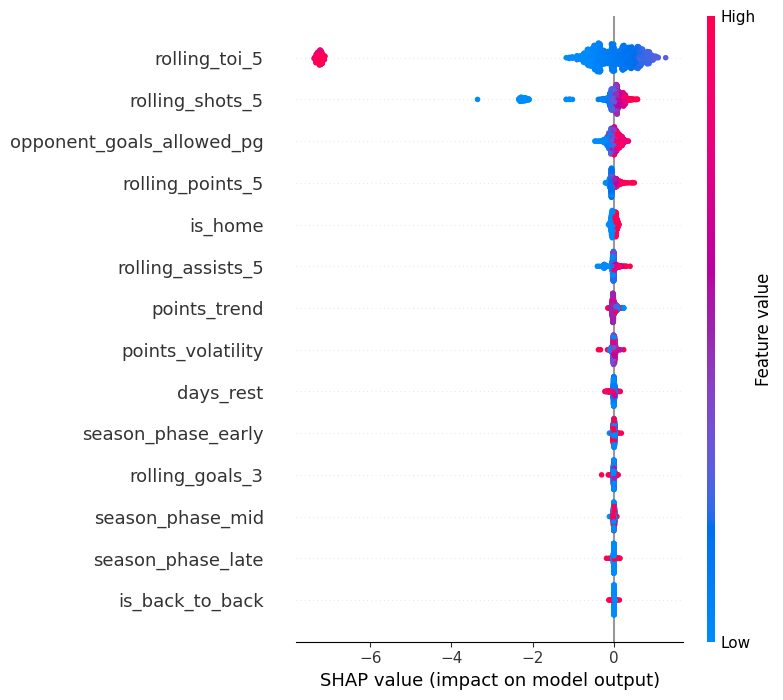

In [4]:
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)

## Bar plot (mean |SHAP|)

Overall feature importance: average magnitude of each feature's impact.

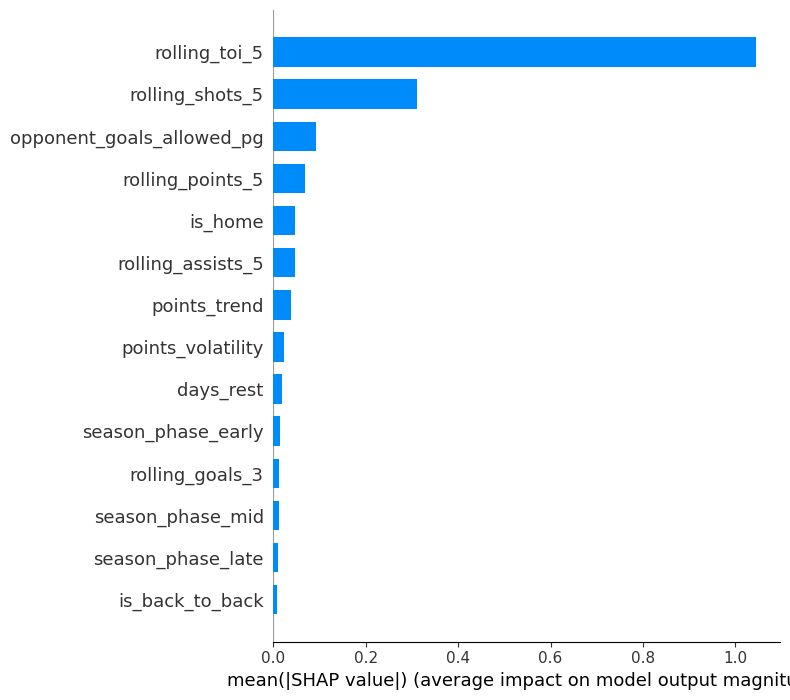

In [5]:
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)

## Dependence plots (top features)

How rolling_shots_5 and rolling_toi_5 (high XGBoost importance) affect predictions.

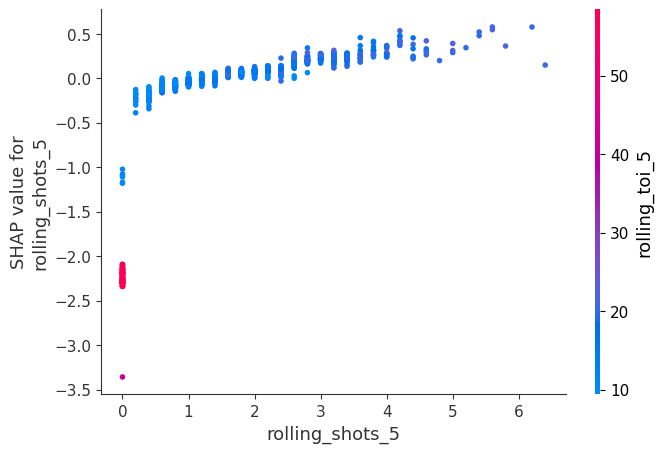

In [6]:
# Dependence: rolling_shots_5 (most important)
shap.dependence_plot("rolling_shots_5", shap_values, X_sample, feature_names=feature_names, show=False)

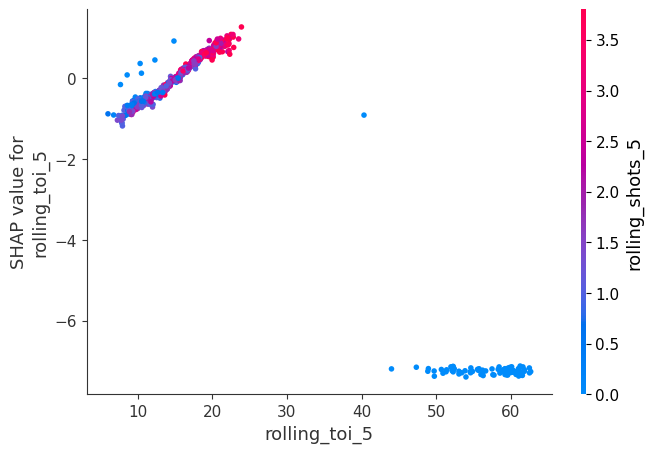

In [7]:
# Dependence: rolling_toi_5 (ice time)
shap.dependence_plot("rolling_toi_5", shap_values, X_sample, feature_names=feature_names, show=False)